# Comparing the effect of WR winds on the orbital velocity versus the kick velocity

The goal of this notebook is to plot evaluate wether it is the orbital widening caused by winds, or the induced kick velocity caused by the smaller core mass (aslo from winds) is the dominant reason for binaries to unbind. 

### In order to get some analytical grasp on this, I will try to compute V_orb and V_kick at different Z in the following situation

* _Star 1 is going SNe_
* Star 1 is a _naked He star_ (assumed to be binary-stripped)
* We start of with the same initial He-core mass (M_He,i) for star 1 at every metallicity 
    (in reallity, less and less stars make it to this M_He,i at higher Z)

* We assume the stars are on a _circular orbit_
* We assume all _mass is lost only from star 1_, through Z-dependent WR winds
* The specific angular momentum losst through this wind is a _fast isotropic wind_ (i.e., Jeans mode mass loss)


In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

from astropy import units as u
from astropy import constants as const
import seaborn as sns

from matplotlib.lines import Line2D

home_dir = os.path.expanduser("~")
datar_root = home_dir + "/ceph/CompasOutput/v02.35.02/"

######################################
## PLOT setttings
plt.rc("font", family="serif")
from matplotlib import rc
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30, 20, 25, 30
for obj in ["axes", "xtick", "ytick"]:
    plt.rc(obj, labelsize=SMALL_SIZE)  # controls default text sizes
for obj in ["figure", "axes"]:
    plt.rc(obj, titlesize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize

# We first compute how much mass is lost given a particular wind-mass loss prescription
as a function of initial He-star mass, and metallicity

*** 

## Final mass 

The final total mass is defined as 

$$
M_{tot,f} = M_{tot, i} - dM_{wind}  =  \boxed{ M_{He,i} \cdot (1 + q) - dM_{wind}, }
$$

assuming mass ratio $q \equiv M_2/M_{He,i} $. To estimate how much mass the star looses during the WR phase, we'll use:

$$
\boxed{dM_{wind} \approx  \dot{M}_{WR} \cdot \tau_{He,MS} }
$$

*** 

## He MS lifetime
the nuclear timescale of the He MS is about 10 times shorter than the nuclear timescale for the H-MS:

$$
\tau_{He,MS} \approx \tau_{MS}/10 = 1/10 \cdot 10^{10} \frac{M_{ZAMS}}{M_{\odot}} \frac{L_{\odot}}{L} yr =  2.9 * 10^{9} \frac{M_{He,i}}{M_{\odot}} \frac{L_{\odot}}{L} yr
$$
Where we've used that $M_{He,i} \approx 0.35 M_{ZAMS}$

*** 
## He,MS luminosity

* From Hurley + 200 we take formulas for the Luminosity of the He MS:

eq 80 at $\tau = 1$ (i.e., terminal age main sequence)

$$
L_{THeMS} = L_{ZHe} (1 + 0.45 + \alpha)
$$

eq. 77:
$$
 L_{ZHe}  = \frac{15262 \cdot  M_{He,i}^{10.25}}{M_{He,i}^{9} + 29.54 \cdot M_{He,i}^{7.5} + 31.18 M_{He,i}^{6} + 0.0469}
$$


eq. 82:
$$
\alpha = max(0,0.85 - 0.08 M_{He,i})
$$


* Alternatively the mass luminosity relation from Grafener (2011)

$$
\log(L/L_{\odot}) = F1 + F2 \cdot \log_{10}(M) + F3 \cdot (\log_{10}(M))^2
$$



In [9]:
###########################################
# Computing the luminosity of a naked helium star
###########################################
# Hurley 2000 : the terminal age He-MS luminosity for a stripped star following Hurley
def L_THEMS(M_hei):
    """
    Hurley 2000
    """
    # eq. 82
    alpha = max(0, 0.85 - 0.08 * M_hei)

    # eq. 77
    L_ZHe = (15262 * M_hei**10.25) / (
        M_hei**9 + 29.54 * M_hei**7.5 + 31.18 * M_hei**6 + 0.0469
    )

    # L_THEMS eq. 80
    L_THEMS = L_ZHe * (1 + 0.45 + alpha)

    return L_THEMS  # L/Lsun


def LM_Grafener2011(M, F1=3.017, F2=2.446, F3=-0.306):
    """Mass Luminosity relation for H-free stars
    eq 10 in
    https://arxiv.org/pdf/1106.5361.pdf
    """
    logL_Lsun = F1 + F2 * np.log10(M) + F3 * np.log10(M) ** 2
    return 10**logL_Lsun


###########################################
# Mass lumminosity relation for naked He stars
L = LM_Grafener2011(22, F1=3.017, F2=2.446, F3=-0.306)  # L/Lsun
print("Using Grafener (2011) logL/Lsun = ", np.log10(L))


L = L_THEMS(22)  # L/Lsun
print("Using Hurely (2000) logL/Lsun = ", np.log10(L))

Using Grafener (2011) logL/Lsun =  5.749123689171438
Using Hurely (2000) logL/Lsun =  5.9126879550772




## WR wind mass loss

We consider a few WR wind-mass loss cases:

#### 1) Z-scaled version of the WR winds from Hamann & Koesterke (1998):
$$
\dot{M}_{WR} = f_{WR} \times 10^{-13} \left( \frac{L}{L_{\odot}} \right)^{1.5} \left( \frac{Z}{Z_{\odot}} \right)^{0.86} \, M_{\odot} \, yr^{-1}
$$
By default $f_{WR} = 1$


#### 2a) Vink (2017) for low luminosity WR stars:
$$
\boxed{ \log \dot{M}_{Vink2017} = -13.3 + 1.36 \log L + 0.61 \log_{10}\left(\frac{Z}{Z_{\text{sun}}}\right) }
$$

#### 2b) Sander & Vink for high luminosity WR stars:
eq. 14 from https://arxiv.org/abs/2009.01849
$$
\boxed{ \dot{M}_{SV2020} = \dot{M}_{10} \left(\log\frac{L}{L_{0}}\right)^{\alpha} \left(\frac{L}{10L_{0}}\right)^{\frac{3}{4}} }
$$

with $\alpha$ defined in eq. 18:
$$
\alpha = 0.32(\pm0.08) \cdot \log\left(\frac{Z}{Z_{\odot}}\right) + 1.40(\pm0.07) 
$$

$\log\left(L_{0}/L\right)$ in eq. 19:
$$
\log\left(L_{0}/L\right) = -0.87(\pm0.02) \cdot \log\left(\frac{Z}{Z_{\odot}}\right) + 5.06(\pm0.02) \quad (19)
$$

and $\log\left(\frac{\dot{M}_{10}}{M_{\odot}\text{yr}^{-1}}\right)$ in eq. 20:
$$
\log\left(\frac{\dot{M}_{10}}{M_{\odot}\text{yr}^{-1}}\right) = -0.75(\pm0.02) \cdot \log\left(\frac{Z}{Z_{\odot}}\right) - 4.06(\pm0.02)
$$


Finally Sander et al. 2023 (https://www.aanda.org/articles/aa/full_html/2023/02/aa45110-22/aa45110-22.html) provide an additional temperature-dependent correction in their eq. 18:

$$
\log\left(\frac{\dot{M}}{M_{\odot}\text{yr}^{-1}}\right) = \log\left(\frac{\dot{M}_{SV2020}}{M_{\odot}\text{yr}^{-1}}\right) - 6 \log\left(\frac{T_{\text{eff}}}{141 \text{kK}}\right)
$$

That we apply whenever $T_{\text{eff}} > 10^5 \text{K}$



#### 2c) Combined WR wind mass loss from Sander & Vink(2020) +  Vink (2017) 
$$
\boxed{ \dot{M}_\mathrm{WR} = \mathrm{max}(\dot{M}_\mathrm{Vink2017}, \dot{M}_\mathrm{SV2023}) }
$$




In [98]:
###########################################
# Different wind-mass-loss prescriptions
###########################################
# Hamman & Koesterke 1998 (default COMPAS)
def HamannKoesterke1998(L, Z, Zsun = 0.014, fWR=1.0):
    """
    Eq 9 from Belczynski 2010
    http://arxiv.org/abs/0904.2784
    Should be based on Hamann & Koesterke 1998: (based on 62 WN stars)
    https://ui.adsabs.harvard.edu/abs/1998A&A...335.1003H/abstract
    But I never actually found this equation in here???
    """
    Mdot = fWR * 1e-13 * (L / const.L_sun) ** 1.5 * (Z / Zsun) ** 0.86
    return Mdot * u.Msun / (u.yr)

# print(HamannKoesterke1998(10000*const.L_sun, 0.014, fWR=1.0) )

##################
# Vink 2017
def Vink2017(L, Z, Zsun=0.014):
    """
    Equation 1 in Vink 2017
    Theoretical mass loss rates for He stars in the range 2-20 Msun
    https://arxiv.org/abs/1710.02010
    Derived for Z/Zsun = 1 − 1e−2 and mass range 2 - 60 Msun
    """
    logL = np.log10(L / const.L_sun)
    logMdot = -13.3 + 1.36 * logL + 0.61 * np.log10(Z / Zsun)

    return logMdot

# print(Vink2017(10000*const.L_sun, 0.014, Zsun=0.014) )


# Sander & Vink 2020
def SanderVink2020(L, Z, Zsun = 0.014):
    """
    Eq 13 and 18-20 in Andreas & Vink 2020
    https://arxiv.org/abs/2009.01849
    
    + Temperature correction from Sander et al. 2023
    https://www.aanda.org/articles/aa/full_html/2023/02/aa45110-22/aa45110-22.html

    !! Takes L in L/Lsun, i.e. 2e5,  (many values return NAN)

    """
    # Mass lumminosity relation for nakeed He stars
    # L = 170761.47525570545 #LM_Grafener2011(M, F1 = 3.017, F2=2.446, F3 = -0.306) #L/Lsun
    # print('for M = ', M, 'L = ', L)
    # general wind mass loss prescription
    alpha      = 0.32 * np.log10(Z/Zsun) + 1.4
    logL0_Lsun = -0.87*np.log10(Z/Zsun) + 5.06 #+ np.log(const.L_sun.value)
    L0         = 10**(logL0_Lsun) #L/Lsun
    logMdot10  = -0.75 * np.log10(Z/Zsun) - 4.06 
    Mdot10     = 10**(logMdot10)
    
    Mdot    = Mdot10 * (np.log(L/L0))**alpha * (L/(10*L0))**(3./4.)

    return np.log10(Mdot) #Msun yr^-1

print(SanderVink2020(2e5, 0.014, Zsun=0.014) )


# Combined WR winds for low and high L combining Vink 2017 + Sander & Vink 2020
def WRwind_SV(L, Z, Zsun=0.014):
    """
    Combined WR wind prescription for low and high luminosity
    """
    M_vink2017 = Vink2017(L*const.L_sun, Z, Zsun=Zsun)
    # print('M_vink2017',M_vink2017)
    M_SV2020 = SanderVink2020(L, Z, Zsun=Zsun)
    # print('M_SV2020', M_SV2020)
    
    # Temperature correction to the SanderVink2020 prescription
    M_SV2023 = M_SV2020  # - 6 * np.log10(Teff)

    return np.maximum(M_vink2017, M_SV2023)

WRwind_SV(2e5, 0.014, Zsun=0.014)


-4.987226008940906


<Quantity -4.98722601>

In [102]:
###########################################
# Computing the mass losst 
###########################################
# estimate of total mass lost from WR-like winds during the He-MS phase
def dM_wind(M_He_i, Z, L_hestar = 'Hurley', WR_wind = 'SanderVink'):
    """
    !!! Make sure to provide:
    M_he in Msun
    Z in Zsun   
    L_hestar  ----- What M-L relation to use ['Hurley', Grafener2011]
    WR_wind   ----- What WR wind mass loss to use [HamannKoest, 'SanderVink']
    """

    # Compute He star luminosity from the mass
    if L_hestar == 'Hurley':
        L_Lsun = L_THEMS(M_He_i)    # 10**5.4 #/const.L_sun.value # Lsun  (taken from Spera + 2019 SEVN paper, fig 1)
    if L_hestar == 'Grafener2011':
        L_Lsun = LM_Grafener2011(M_He_i)
    print( 'L_Lsun', L_Lsun, '\n')

    # Calculate He main sequence time
    tau_He_MS = 2.9e9 * (M_He_i) * L_Lsun**-1 #(L_sun/L)  # in years
    print('tau_He_MS', tau_He_MS*1e-6, 'Myr \n')

    if WR_wind == 'SanderVink':
        dotM_WR = 10**WRwind_SV(L_Lsun, Z, Zsun = 0.014)
    if WR_wind == 'HamannKoest':
        dotM_WR = HamannKoesterke1998(L_Lsun*const.L_sun, Z, fWR = 1.).value
    print('dotM_WR',dotM_WR)

    dM_wind = tau_He_MS * dotM_WR

    return dM_wind # Msun


dM_wind(10, 0.014, L_hestar = 'Hurley', WR_wind = 'SanderVink') 


L_Lsun 207142.9405269809 

tau_He_MS 0.1399999436438563 Myr 

dotM_WR 1.1520776952248872e-05


<Quantity 1.61290812>

In [103]:
# Calculate final He-core mass post wind mass loss
def M_tot_f(M_He_i, q, wind_mass_loss):
    M_tot_f = M_He_i * (1 + q) - wind_mass_loss
    return M_tot_f


# Final separation due to wind mass loss widening
def a_f(a_i, M_tot_i, M_tot_f):
    return a_i * (M_tot_i / M_tot_f)


# Circular orbital velocity
def v_orb(M_tot_f, a_f):
    """
    a_f in Rsun
    M_tot_f in Msun
    """
    G_new_units = const.G.to(u.Rsun**3 / u.Msun / u.yr**2)

    v_orb = np.sqrt(G_new_units * M_tot_f / a_f)

    return v_orb.to(u.km / u.s)

# Computing the orbital Velocity, v_orb

## Circular orbital velocity

$$
\boxed{v_{orb} = \sqrt{\frac{G M_{tot,f}}{a_f} }}
$$


## Fast or Jeans mode mass loss
We know that 

$$
a(M_1 + M_2) = const
$$

(see e.g., Pols lecture notes for full derivation in this case)
This means that 
$$
\frac{d a M_{tot}}{dt} = 0 \rightarrow   \frac{da}{dt}M_{tot} + a \frac{dM_{tot}}{dt} = 0 \rightarrow \frac{da}{dt a} = \frac{-dM_{tot}}{dt M_{tot}}
$$

integrating this
$$
\int_{a_i}^{a_f} \frac{da}{dt a} dt = \int_{M_{tot,i}}^{M_{tot,f}}\frac{-dM_{tot}}{dt M_{tot}} dt = \ln(\frac{a_f}{a_i}) = \ln(\frac{M_{tot,i}}{M_{tot,f}})
$$

or

$$
\boxed{a_f = a_i \frac{M_{tot,i}}{M_{tot,f}}}
$$



In [104]:
M_He_i = 10  # Msun

# It's more natural to pick q_zams: q_ZAMS = 0.35 * q
q_zams = 1
q = q_zams / 0.35

m2 = q * M_He_i
print("m2", m2)

Z = 1e-4 / 0.014

# initial separation in Rsun
a_i = 500  # Rsun

Mtot_initial = M_He_i * (1 + q)
print("Mtot_initial", Mtot_initial)

# Estimate wind mass lost
wind_mass_loss = dM_wind(M_He_i, Z)
print("wind_mass_loss", wind_mass_loss)

Mtotfinal = M_tot_f(M_He_i, q, wind_mass_loss)
print("Mtotfinal", Mtotfinal)

print("Mtot_initial / Mtotfinal", (Mtot_initial / Mtotfinal))

final_separation = a_f(a_i, Mtot_initial, Mtotfinal)
print("final_separation", final_separation)

orbital_vel = v_orb(Mtotfinal * u.Msun, final_separation * u.Rsun)
print("orbital_vel", orbital_vel)

m2 28.571428571428573
Mtot_initial 38.57142857142857
L_Lsun 207142.9405269809 

tau_He_MS 0.1399999436438563 Myr 

dotM_WR 5.647434243286039e-07
wind_mass_loss 0.07906404757924297
Mtotfinal 38.492364523849325
Mtot_initial / Mtotfinal 1.0020540189868112
final_separation 501.0270094934056
orbital_vel 121.06024291409096 km / s


# Computing the kick velocity v_kick

$$
v_{kick} = v_{NS,kick} (1-f_{fb})
$$
Where $v_{NS,kick}$ is a kick drawn from a Maxwell-Boltzmann distribution with $\sigma_{kick} = 265 km/s$

The fallback fraction $f_{fb}$ is defined in Fryer +2012:

$$
f_{fb} = a_2 M_{CO} + b_2 
$$


$$
f_{fb} = 
\begin{cases} 
a_2 M_{CO} + b_2 &  3.5 M_{\odot} \leq M_{CO} < 11M_{\odot} \\
1.0 &  M_{CO} \geq 11 M_{\odot} \\
\end{cases}
$$

$$
a_2 = 0.133 - \left(0.093/M - M_{proto} \right)
$$

$$
b_2 = -11 a_2 + 1
$$

and with 

$$
M_{proto} = 
\begin{cases} 
1.2 &   & M_{CO} < 3.5M_{\odot} \\
1.3 &  3.5 M_{\odot} \leq & M_{CO} < 6 M_{\odot} \\
1.4 &  6 M_{\odot} \leq & M_{CO} < 11 M_{\odot} \\
1.6 &   & M_{CO} \geq 11 M_{\odot} \\
\end{cases}
$$

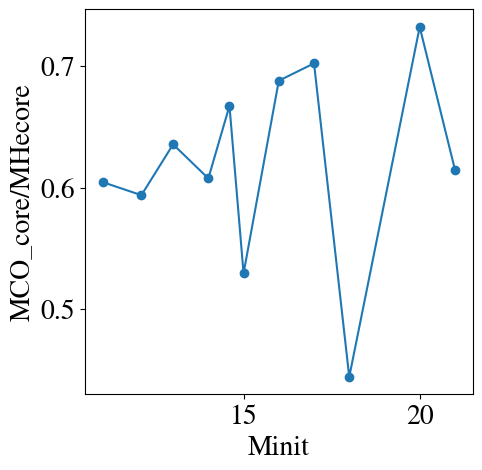

In [105]:
# To estimate what fraction of the He-core is in the CO-core
# From Eva's Table 1 (Different to the core)
# https://arxiv.org/abs/2102.05036

Minit = np.array([11.0, 12.1, 13.0, 14.0, 14.6, 15.0, 16.0, 17.0, 18.0, 20.0, 21.0])
MCO_core = np.array([1.88, 2.09, 2.46, 2.57, 2.99, 2.44, 3.42, 3.73, 2.49, 4.60, 4.07])
MHecore = np.array([3.11, 3.52, 3.87, 4.23, 4.48, 4.61, 4.97, 5.31, 5.61, 6.28, 6.62])

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(Minit, MCO_core / MHecore, label="binary stripped", marker="o")
plt.xlabel("Minit")
plt.ylabel("MCO_core/MHecore")
plt.show()

In [106]:
def a_2(M, M_proto):
    return 0.133 - (0.093 / (M - M_proto))


def b_2(a_2):
    return -11 * a_2 + 1


def M_proto(M_CO):
    if M_CO < 3.5:
        return 1.2
    elif 3.5 <= M_CO < 6:
        return 1.3
    elif 6 <= M_CO < 11:
        return 1.4
    else:  # M_CO >= 11
        return 1.6


def f_fb(M):
    # Assume about 60% of He core forms CO core
    M_CO = 0.6 * M
    # print('M_CO', M_CO)

    # M_proto
    proto_core_mass = M_proto(M_CO)
    # print('proto_core_mass', proto_core_mass)

    a2 = a_2(M, proto_core_mass)
    b2 = b_2(a2)

    if 3.5 <= M_CO < 11:
        return a2 * M_CO + b2
    elif M_CO >= 11:
        return 1.0
    else:
        return None


# We assume its a stripped star with mass M = M_He_i
fallback_fraction = f_fb(M_He_i)
print("f_fb", fallback_fraction)

print(1 - fallback_fraction)

f_fb 0.3890697674418605
0.6109302325581395


In [107]:
# draw a natal-kick from a Maxwell-Boltzmann distribution
sigma_kick = 265  # km/s
scale = sigma_kick  # / np.sqrt(2)

# Draw a single value of Maxwell-Boltzmann distribution
# scale = a in https://mathworld.wolfram.com/MaxwellDistribution.html
v_kicks = stats.maxwell.rvs(scale=scale, size=1000)  # get a 100 values at once

# Get the 10th, 50th and 90th percentile
v_kick_10 = np.percentile(v_kicks, 10)
v_kick_50 = np.percentile(v_kicks, 50)
v_kick_90 = np.percentile(v_kicks, 90)

print("v_kick_10", v_kick_10, "v_kick_50", v_kick_50, "v_kick_90", v_kick_90)

v_kick_10 206.3522125319976 v_kick_50 404.39888219526165 v_kick_90 661.1606019004101


In [117]:
# initial parameters
def get_v_orb_and_f_fb(M_He_i=20, q_zams=0.7, a_i=1000, 
                       z_list=np.logspace(-4, np.log10(0.03), 100) / 0.014):
    """
    M_He_i: initial He core mass in Msun
    q_zams: initial mass ratio
    a_i: initial separation in Rsun
    z_list: list of metallicities/Zsolar
    """
    # print('z_list', z_list))

    q = q_zams / 0.35

    Mtot_initial = M_He_i * (1 + q)
    print("Mtot_initial", Mtot_initial)

    wind_mass_loss = dM_wind(M_He_i, Z, L_hestar = 'Hurley', WR_wind = 'HamannKoest')
    M_He_f = M_He_i - wind_mass_loss
    print('M_He_f', M_He_f)

    Mtotfinal = M_tot_f(M_He_i, q, wind_mass_loss)
    final_separation = a_f(a_i, Mtot_initial, Mtotfinal)

    orbital_vel = v_orb(Mtotfinal * u.Msun, final_separation * u.Rsun)

    # received kick as a function of Z
    fallback_fraction = f_fb(M_He_f) # np.array([f_fb(m) for m in M_He_f])  # We assume its a stripped star with mass M = M_He (post wind mass loss)

    return z_list, q, orbital_vel, fallback_fraction

Mtot_initial 43.71428571428572
L_Lsun 589360.388269554 

tau_He_MS 0.08857059456144759 Myr 

dotM_WR 2.5364785445149618e-05
M_He_f 15.753425872199546


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

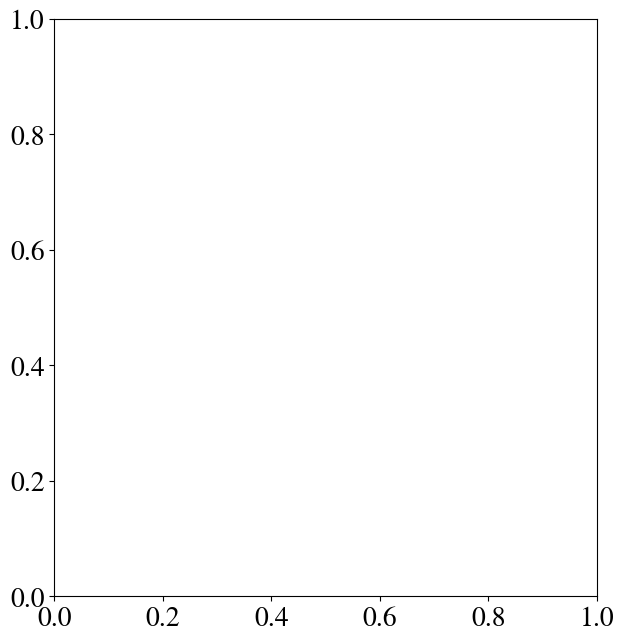

In [118]:
####################################
# Define a few parameters
# colors = sns.cubehelix_palette(start=2, rot=0.2, dark=0.1, light=.7, reverse=True, n_colors = 3)
colors = sns.color_palette("viridis", 3)
# colors = ['#5EA29C',  '#ffc000', '#E44D4D']
colors = ["#004762", "#74BC6A", "#D9D55A"]
initial_helium_masses = [18, 22, 35]

zams_mass_ratio = 0.5
zams_separation = 500  # Rsun
####################################
fig, ax = plt.subplots(figsize=(7, 7.5))
for i, he_mass in enumerate(initial_helium_masses):
    z_list, q, orbital_vel, fallback_fraction = get_v_orb_and_f_fb(M_He_i=he_mass, q_zams=zams_mass_ratio, a_i=zams_separation)

    # Orbital velocity as a funciton of Z
    plt.plot(np.log10(z_list),orbital_vel,
             lw=5,color=colors[i],ls="-", label="$v_{\mathrm{orbital}}$ mhe = " + str(he_mass) + "Msun")

    # Kick velocities reweighted by f_fb
    plt.plot( np.log10(z_list), v_kick_50 * (1 - fallback_fraction), 
             lw=4, ls="--", color=colors[i], label="$v_{\mathrm{kick}}$ mhe = " + str(he_mass) + "Msun")
    plt.fill_between( np.log10(z_list), y1=v_kick_10 * (1 - fallback_fraction), y2=v_kick_90 * (1 - fallback_fraction),
        color=colors[i],alpha=0.2,label=None)

# Annotate the used q_zams and a_zams
plt.text(0.35,0.98,
    f"$M_{{\mathrm{{comp}}}}/M_{{\mathrm{{He,i}}}}= {np.round(q,2)}$\n$a_{{\mathrm{{ZAMS}}}} = {zams_separation}$"
    + "$\, \mathrm{R_{\odot}}$",
    ha="left",va="top", transform=ax.transAxes,fontsize=20,)

# Legend for the He masses
legend_elements1 = [Line2D([0], [0], color=colors[i], lw=4, label=f"{he_mass}" + "$M_{\odot}$")
    for i, he_mass in enumerate(initial_helium_masses)]
legend1 = ax.legend(handles=legend_elements1, loc="upper left", title="$M_{\mathrm{He,i}}$")

# Legend for the orbital and kick velocities
legend_elements2 = [
    Line2D([0], [0], color="k", lw=4, ls="-", label="$v_{\mathrm{orbital}}$"),
    Line2D([0], [0], color="k", lw=4, ls="--", label="$v_{\mathrm{kick}}$"),
]
legend2 = plt.legend(handles=legend_elements2, loc="center left", bbox_to_anchor=(0, 0.6), fontsize=20)

ax.add_artist(legend1)

plt.xlabel("$\log_{10}(Z/\mathrm{Z}_{\odot}$)", fontsize=30)
plt.ylabel("$\mathrm{velocity \ km/s}$", fontsize=30)
plt.ylim(0, 350)
plt.xlim(np.log10(1e-4 / 0.014), np.log10(0.03 / 0.014))
# plt.savefig(f"../plots/v_kick_v_orb.pdf", bbox_inches="tight")
plt.show()